In [114]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
#from sklearn import datasets
import pandas as pd
import nltk
import nltk
#nltk.download('punkt')
from utilidades import *
import numpy as np
from sklearn.metrics import f1_score as f1, accuracy_score as acc
%matplotlib inline  
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Word Embedings

De igual forma que las técnicas de vectorización vistas hasta ahora, los word embeddings  se utilizan para transformar texto a una forma numérica en forma de vectores. La  transformación resultante a diferencias de las listas de posteo y bag of words produce vectores densos de dimension $N$ (embeber las palabras en espacio de dimensión $N$). A cada palabra se le asigna un vector único de tal forma que palabras similares deben tener vectores cercanos entre sí. 

Por ejemplo si se tiene el siguiente vocabulario:

**$V=\{$pepe, pecas, pica, papas, pico$\}$**

La aproximación directa sería utilizar **one-hot encoding**, esto es utilizar vectores de dimensión $N=|V|$ donde |V| es el tamaño del vocabulario (para este ejemplo $|V|=5$). 

| Palabra       | pepe | pecas |pica | papas| pico |
| ------------- | ---- | ---- | ---- | ---- |---- |
| $\overrightarrow{pepe}$ |  1   |   0  |   0  |   0  | 0 |
| $\overrightarrow{pecas}$ |  0   |   1  |   0  |   0  | 0 |
| $\overrightarrow{pica}$ |  0   |   0  |   1  |   0  | 0 |
| $\overrightarrow{papas}$  |  0   |   0  |   0  |   1 | 0 |
| $\overrightarrow{pico}$  |  0   |   0  |   0  |   0 | 1|


Esto resulta en vectores dispersos, los cuales no proporcionan información acerca de las relaciones que existen entre las palabras (por ejemplo pica y pico). Podemos ver esa situación graficamente, pero cómo nuestros datos están en 5 dimensiones utilizaremos PCA, para reducir la dimensión de los datos.

In [4]:
# Los datos para este ejemplo
V=np.array(['pepe', 'pecas','pica', 'papas', 'pico']) #el vocabulario
# la representación en one-hot encoding
X=np.array([[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]])
clases=dict(zip(V,X)) # usaremos una clase por cada palabra
print(clases)

{'pepe': array([1, 0, 0, 0, 0]), 'pecas': array([0, 1, 0, 0, 0]), 'pica': array([0, 0, 1, 0, 0]), 'papas': array([0, 0, 0, 1, 0]), 'pico': array([0, 0, 0, 0, 1])}


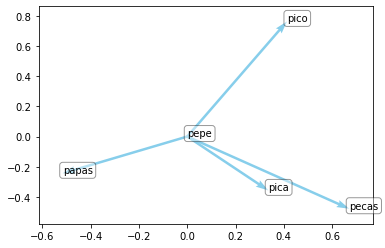

In [12]:
# Función para aplicar pca y graficar los vectores en 2 y 3 dimensiones (default 2d).
plotPCA(X,labels=V)

podemos ver que en un espacio de dos dimensiones las palabras **pica** y **pico** se representan con vectores "lejanos", el ángulo entre ellos es grande. Esta representación son los word embeddings *one-hot encoding*

Aún cuando *one-hot encoding* es un embedding válido, este es disperso y no dice nada acerca de cómo se relacionan la palabras entre ellas. Desearíamos que el embedding  pudiera expresar las similitudes y diferencias semánticas entre ellas, por ejemple si dos palabras significan lo mismo (son sinónimos), son términos opuestos (antónimos) o si en algún contexto podrían significar lo mismo. 

Algunos ejemplos de relaciones que se podrían capturar serían por ejemplo que palabras como: *Paris, Teherán, Tokio, Canberra*  están relacionadas con la palabra capital, o *México, Estados Unidos, Canada* se relacionan con el término *Norte América*.   

Los generación de word embeddings parte de la idea de que el significado de una palabra es afectado por las palabras en torno suyo. Una de las primeras ideas que se puede tener si se cuenta con un corpus de documentos, es crear una matriz de co-currencia con todo el vocabulario, es decir el contexto de  cada palabra está dado por todas las palabras de las que aparece rodeada, es decir su contexto. Por ejemplo si se tiene la siguiente colección de documentos:

In [25]:
t1="amlo, meade, anaya fueron candidatos a presidente"
t2="amlo tiene doce años intentando ser presidente"
t3="meade es el candidato del presidente peña"
t4="peña fue presidente de méxico"
t5="amlo es el eterno candidato a presidente"
coleccion=[t1,t2,t3,t4,t5]
tokens_list=tokenize_sentences(coleccion)
# funcion simple para calcular la matriz co-ocurrencia
voc,X_co=cocurrency_matrix(tokens_list) 
X_co # La matriz  de co-ocurrencia completa

,amlo,anaya,anos,candidato,candidatos,doce,eterno,intentando,meade,mexico,pena,presidente,ser
amlo,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,1.0
anaya,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
anos,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
candidato,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0
candidatos,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
doce,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
eterno,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
intentando,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
meade,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0
mexico,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [26]:
# Veamos solo una porción que relaciona a las personas ['amlo','meade','pena'] con el
# contexto dado por ['candidato','presidente','mexico']
X_co.loc[['amlo','meade','pena']][['candidato','presidente','mexico']]

,candidato,presidente,mexico
amlo,1.0,3.0,0.0
meade,1.0,2.0,0.0
pena,1.0,2.0,1.0


Podemos ver que todas las personas están relacionadas con las palabras *candidato* y *presidente* y que *amlo* tiene una mayor co-ocurrencia con presidente. El problema con la matriz es que puede ser muy grande. ¿Qué tan grande? $|V| \times |V|$

Lo ideal es reducir la dimensión de la matriz lo más simple es realizarlo mediante una factorización:

Matriz Original | Factorización &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
--------------- | ----------------------------------
$X_{co}$        | $U_{word}*V_{context}$                               
$|V|\times |V|$ | $(|V| \times N) * (N \times |V|)$

Para nuestro ejemplo la primera fila de $X$ corresponderá al embedding para la palabra **amlo**. La reducción puede realizarse mediate una factorización donde $X=U_{word}*V_{context}$. La forma más popular es mediante el uso de redes neuronales profundas.

### Word2Vec

Word2Vec genera los words embedding mediandte el uso de dos métodos: Continous Bag of Words (CBOW) y Skip Gram, ambos basados en redes neuronales.

#### CBOW

CBOW toma como entrada un contexto $C$ de tamaño $|C|$ y trata de predecir la palabra que corresponde. Esto es similar a como realizamos los examenes de Inglés cuando tenemos que completar una oración a la que le falta una palabra. Por ejemplo si tenemos la siguiente sentencia: 


**____ there a restaurant near here?**

el contexto estaría dado por los one hot encodings para los tokens $\{there, a, restaurant, near, here\}$ ($\{y_1,y_2,...y_5\}$) y se mediría el error con respecto al one hot encoding de salida para la palabra $x_i=is$. Se utiliza una red neurolal con una capa oculta para ajustar los pesos corresponcientes a cada palabra usando contextos de tamaño |C| (ver la siguiente figura).

|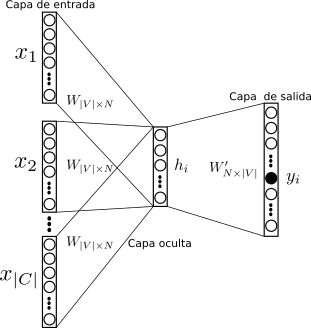|
|:--:| 
|**CBOW**|

donde

 - $W$  es la matriz de pesos que mapea las entradas $x_{i}$ a la capa oculta. Generalmente se toma el promedio de todas las palabras en el contexto $C$
 - $W^{'}$ es la matriz de pesos que mapea las salidas de capa oculta a la capa de salida.

La palabra que se quiere aprender puede ser vista como una palabra "central" y las palabras en torno a ella, serían su contexto. Así podemos ver el contexto $C$ en términos de un tamaño de ventana **window_size  ($\mathit{ws}$)** (lo relacionaremos con los parámetros de los modelos para word embeddings). 


|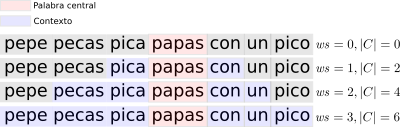|
|:--:| 
|**Posibles contexto para diferentes valores de $\mathit{ws}$**|

La figura no contempla todos los posibles contextos, solo ilustra los simétricos. Aunque que Mikolov et al en [3] que los mejores resultados para la tare reportada los obtinen con CBOW utilizando una ventana simétrica de 4.  

####  Skip-Gram

Skip-Gram puede verse básicamente como un CBOW inverso, donde a partir de una palabra se predice su contexto. Es decir para cada posible posición de una palabra en un contexto dado, se obtienen $|C|$ distribuciones de probabilidad con $|V|$ probabilidades cada una.

|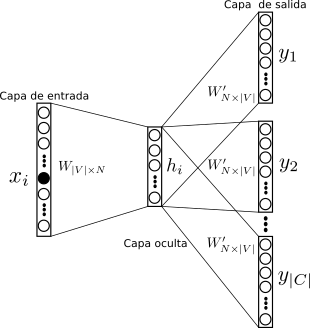|
|:--:| 
|**Skip-Gram**|

Algunas de las ventajas de un método con respecto de otro de acuerdo con Mikolov son: el modelo Skip Gram es mejor cuando se tienen pocos datos y es bueno para representar palabras poco frecuentes, mientras que CBOW es más rápido y produce mejores representaciónes de palabras frecuentes.


### FastText

Es una versión muy popular de embeddings propuesto por Facebook, FastText utiliza el contexto considerando todas las subwords(sub-palabras) para cada término en el vocabulario. Es decir utiliza $q$-gramas con el fin de considerar la morfología de las palabras durante el aprendizaje del modelo. Por ejemplo la palabra **pasear** para $ 2 \leq q \leq 3$ resultaría en los $q$-gramas de 2 y 3 caracteres **{pas, ase, ear, pa, as, se, ea, ar}**. Cuando se utilizan subwords, cada vector es el resultado de la suma de los vectores para cada una de los $q$-gramas. FastText al igual que Word2Vec utiliza los modelos CBOW y Skip-Gram. 

## Gensim

Es una biblioteca para realizar modelado semántico no supervisado a partir colecciones de documentos de texto. En particular estamos interesado en la implementación de Gensim para FastText. 

In [38]:
#Podemos utilizarlo 
#! pip install gensim # si no está instalado
#! conda install gensim 
from gensim.models import FastText

Algunos de sus parametros son:
    
- **sentences**: Puede ser una lista de listas de tokens, pero para coleciones grandes pueden utilizarse streams iterables directamentes desde disco o la red.
- **min_count**: Se ignoran las palabras con una frecuencia de ocurrencia menor que este valor (default=1).
- **size**: La dimensión de los vectores (default=100).
- **window**: La distancia máxima dentro de una sentencia con respecto a la palabra a predecir (recuerde el contexto y $\mathit{ws}$, default=5) 
- **sg**: El algoritmo de aprendizaje skip-gram si sg=1, CBOW de otra forma.
- **min_n**: Longitud mínima de $q$-grams (default=0).
- **max_n**: Longitud mínima de $q$-grams. Si max_n<min_n no se utilizan los $n$-grams (default=0).
- **word_ngrams**: Si es 1, se utilizan los vectores para sub-palabras ($n$-grams). Si es   0, es equivalente a Word2Vec (default=1).
- **epoch**: Número de epocas (default=5).

In [27]:
# Revisemos un ejemplo
train_df=pd.read_csv('data/humor/train_english.tgz', compression='gzip',usecols=['is_humor','text'])
test_df=pd.read_csv('data/humor/dev_english.csv',usecols=['is_humor','text'])
train_df=train_df.dropna().astype({'is_humor': 'int32'})
test_df=test_df.dropna().astype({'is_humor': 'int32'})

In [28]:
print(len(train_df.text)) # número de tweets

8000


In [30]:
# para porbar solo con un subconjuto de 8000 tweets 
tokens=tokenize_sentences(train_df.text)

In [32]:
tokens[100]

['last',
 'night',
 'my',
 'wife',
 'and',
 'i',
 'watched',
 '2',
 'hours',
 'of',
 'cooking',
 'shows',
 'before',
 'she',
 'hugged',
 'and',
 'went',
 'to',
 'bed',
 'im',
 'pretty',
 'sure',
 'im',
 'in',
 'the',
 'friend',
 'zone']

In [39]:
# Tiempo de generación del vocavulario para los 8000 tweets
%timeit
#Defininmos los parametros del modelo y generamos el vocabulario
model = FastText(size=100, window=3, min_count=1, min_n=2, max_n=4)
model.build_vocab(sentences=tokens)

In [15]:
model = FastText(size=100, window=3, min_count=1, min_n=2, max_n=4)
model.build_vocab(sentences=tokens)

In [46]:
#Podemos ver el vocabulario usando model.wv.vocab
print("Tamaño del vocabulario: ",len(model.wv.vocab))
list(model.wv.vocab)[:10] #solo vemos los primeros 10 elemetos

Tamaño del vocabulario:  15213


['tennessee',
 'were',
 'the',
 'best',
 'state',
 'nobody',
 'even',
 'comes',
 'close',
 'elevennessee']

In [41]:
model.train(sentences=tokens,total_examples=len(tokens), epochs=5)

In [42]:
# El modelo nos permite el acceso a los word embedding de forma indizada
#obtenemos las primeras 10 features del word embedding "peje"
model.wv['tennessee'][1:10] 

array([0.12648474, 0.23166302, 0.41765085, 0.06809738, 0.6353527 ,
       0.26070875, 0.521483  , 0.16620561, 0.37434587], dtype=float32)

In [54]:
# es posible calcular la distancia entre dos palabras utilizando los indices
print("distancia entre woman y man:", model.wv.distance('woman','wife'))
print("distancia entre woman y tennessee:", model.wv.distance('woman','man'))

distancia entre woman y man: 0.07271158695220947
distancia entre woman y tennessee: 0.007259190082550049


In [57]:
# calcular la distancia entre una palabra y un conjunto de palabras
# todas las palabras deben estar en el vocabulario
words_list=['woman','man','tennessee','wife','children']
dists=model.wv.distances('man',words_list)
for w,d in zip(words_list,dists):
    print("distancia entre presidente y %s : %s" %(w,d) )

distancia entre presidente y woman : 0.00725919
distancia entre presidente y man : 0.0
distancia entre presidente y tennessee : 0.0305022
distancia entre presidente y wife : 0.090316474
distancia entre presidente y children : 0.020372689


In [62]:
# no es posible utilizar palabras que no estén en el vocabulario con distances
try:
    w='Children'
    model.wv.distances('Children',[w]) #recuerden que todo lo pasamos a minusculas
except KeyError:
    print("key %s not found" %w )


key Children not found


In [63]:
#pero si con distance
model.wv.distance('Children','children')

0.00018805265426635742

In [64]:
# Podemos obtener los word embbedings de palabras que no estan en el vocabulario
print("esta la palabra son?: ", 'Children' in model.wv.vocab)
# uno de los beneficios de usar subwords 
print("No importa este es su word embedding: ", model.wv['Children'])

esta la palabra son?:  False
No importa este es su word embedding:  [ 0.1824554   0.08255995  0.17674161  0.3451457  -0.04753212  0.57964545
  0.17482656  0.45741835  0.17817648  0.2907769  -0.33081675 -0.9158318
  0.3031999  -0.38963187  0.19058533  0.4292277  -0.57171375 -0.29364648
  0.24005426  0.2543974   0.6778117   0.44437408  0.13666727  0.331468
 -0.03010703 -0.00453224  0.43162957  0.02833229  0.60437936 -0.33419666
  0.15566199 -0.17856765  0.72025585 -0.02165779  0.3578782  -0.07629067
  0.07105778 -0.00486409  0.32094377 -0.29296032  0.15686753  0.22123311
 -0.18057364 -0.11895902  0.4006938   0.23216039 -0.17072158  0.19333267
  0.3740338  -0.26225382  0.02207747 -0.4330518  -0.19488168 -0.6648915
  0.02557234  0.07148401 -0.1957023  -0.28622618 -0.09006874  0.36807582
  0.26905033 -0.5787207  -0.71503764  0.13762334  0.31857118  0.3531153
 -0.13598718  0.05661442 -0.24924521  0.32866687 -0.16974938 -0.02973154
  0.55480504 -0.05555548 -0.03589917 -0.35324052 -0.6365571  

In [69]:
# Su distancia coseno
model.wv.distance('Children','children')

0.00018805265426635742

Una forma simple de calcular el embedding de una sentencia o secuencia de palabras (**sentence embeddings**) es utilizando la media por dimension de los embeddings para cada palabra en la secuencia:

In [76]:
s="Thats a sample sentence"
st=tokenize_sentences(np.array([s])) # tokenizamos la sentencia
print("Sentencia tokenizada: ",st)
# se pueden obtener los embeddings para una lista de palabras
ste=model.wv[st[0]] #obtenemos los embeddings para cada palabra
print("Obtenemos %s vectores de dimension %s" %ste.shape)
sentence_embedding=np.mean(ste,axis=0) 
print("Usamo la media para obtener un solo vector de dimension :%s" %sentence_embedding.shape, 
      sentence_embedding.shape)

Sentencia tokenizada:  [['thats' 'sample' 'sentence']]
Obtenemos 3 vectores de dimension 100
Usamo la media para obtener un solo vector de dimension :100 (100,)


In [90]:
#Podemos evaluar que es más similar
print("distancia entre %s y %s: " %('sentece', s),
      model.wv.distance('sentece',s))
print("distancia 'sentence' y el sentence embbeding:", 
      coseno(model.wv['sentece'],sentence_embedding))

distancia entre sentece y Thats a sample sentence:  0.004646420478820801
distancia 'sentence' y el sentence embbeding: 0.008653819561004639


### Clasificando con FastText embeddings

In [106]:
#tokenizamos
tokens=tokenize_sentences(train_df.text)
tokens_test=tokenize_sentences(test_df.text)
print("Ejemplo de tweet tokenizado: ",tokens[900])

Ejemplo de tweet tokenizado:  ['arthur', 'guinness', 'founder', 'of', 'guinness', 'beer', 'signed', '9000', 'year', 'lease', 'for', 'a45', 'per', 'year', 'at', 'the', 'st', 'jamess', 'gate', 'brewery', 'in', 'dublin', 'back', 'in', '1759']


In [136]:
# definimos el modelo 
ft_model = FastText()

In [137]:
#construimos el vocabulario
ft_model.build_vocab(sentences=tokens)

In [138]:
# Entremanos el modelo
model.train(sentences=tokens,total_examples=len(tokens), epochs=10)

In [139]:
# generamos los embeddings
train=np.array([np.mean([ft_model.wv[token] for token in tweet],axis=0) 
                   for tweet in tokens])
test=np.array([np.mean([ft_model.wv[token] for token in tweet],axis=0) 
                   for tweet in tokens_test])
yt=test_df.is_humor

In [140]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(train,train_df.is_humor)
yp=clf.predict(test)

In [141]:
print(f'f1:{f1(yt,yp)} Accuracy:{acc(yt,yp)}') 

f1:0.7745098039215685 Accuracy:0.632


## Modelos pre-entrenados

Como pudo apreciar en el ejercicio anterior el performance para los embeddings de FastText fue menor que para el caso de TF-IDF, esto en parte se debe a que se entreno el modelo con relativamente pocos datos. 

Los modelos basado en aprendizaje profundo usualmente son costosos de entrenar por lo que una práctica común, es pre-entrenar con grandes cantidades de datos y generar un modelo que puede ser después incorporado a un problema en particular. Gensim ya cuenta con varios modelos de este tipo

In [145]:
import gensim.downloader as api
# Ver los modelos disponibles en gensim-data
print('\n'.join(list(api.info()['models'].keys())))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [151]:
#Prodriamos utilizar como sigue (es de aproximadamente 1GB):
model_pretrain= api.load('fasttext-wiki-news-subwords-300')

In [150]:
# Como ya está entrenado solo lo usamos para generar los embeddings
train2=np.array([np.mean([model_pretrain.wv[token] for token in tweet],axis=0) 
                   for tweet in tokens])
test2=np.array([np.mean([model_pretrain.wv[token] for token in tweet],axis=0) 
                   for tweet in tokens_test])
clf2 = LinearSVC()
clf2.fit(train,train_df.is_humor)
yp=clf2.predict(test2)
print(f'f1:{f1(yt,yp)} Accuracy:{acc(yt,yp)}') 

NameError: name 'model_pretrain' is not defined

## Referencias

1. Manning, C., Raghavan, V. and Schütze H. (2009). Introduction to Information Retrieval (Chapter 16). Cambridge: Cambridge University Press, Online Edition (https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf).
2. Rokach, L., & Maimon, O. (2005). Clustering methods. In Data mining and knowledge discovery handbook (pp. 321-352). Springer, Boston, MA.
3. Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781.
4. Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). Distributed representations of words and phrases and their compositionality. In Advances in neural information processing systems (pp. 3111-3119).
5. Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). Enriching word vectors with subword information. Transactions of the Association for Computational Linguistics, 5, 135-146.
6. Tan, P. N. (2018). Introduction to data mining (Chapter 8). Pearson Education India.
7. Im Walde, S. S. (2006). Experiments on the automatic induction of German semantic verb classes. Computational Linguistics, 32(2), 159-194.
9. Karani, D. (2018). Introduction to Word Embedding and Word2Vec. https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa
10. Rehurek, R.  (2019). FastText model. https://radimrehurek.com/gensim/models/fasttext.html

